# Customer Churn

## Comprensione del dominio

La *customer churn* è una cifra percentuale rappresentante la quantità dei clienti persi in un determinato periodo di tempo: può essere calcolata dividendo il numero dei clienti che hanno reciso i contatti in quel lasso di tempo, per il numero di clienti che si avevano all'inizio dello stesso periodo.

## Comprensione del dataset

**N.B.** Sono presenti anche algoritmi non affrontati a lezione come (Random Forest e XGBoost) come semplice spunto di approfondimento per le future lezioni

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from sklearn.feature_selection import chi2, SelectKBest, f_classif
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, recall_score, RocCurveDisplay, confusion_matrix, classification_report, precision_recall_curve, auc

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.basemap import Basemap

%matplotlib inline

import warnings

In [3]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['figure.facecolor'] = 'whitesmoke'

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
data = pd.read_csv("Telco_customer_churn.csv")
data.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

Colonne:
- **CustomerID**
- **Count**
- **Country**: United States
- **State**: California
- **City**
- **Zip Code**: codici postali
- **Lat Long**: latitudine, longitudine
- **Latitude**
- **Longitude**
- **Gender**
- **Senior Citizen**: cliente anziano oppure no
- **Partner**: cliente con partner oppure no
- **Dependents**
- **Tenure Months**: mesi di permanenza
- **Phone Service**
- **Multiple Lines**
- **Internet Service**
- **Online Security**
- **Online Backup**
- **Device Protection**
- **Tech Support**
- **Streaming TV**
- **Streaming Movies**
- **Contract**
- **Paperless Billing**: fatturazione non cartacea
- **Payment Method**
- **Monthly Charges**: spese mensili
- **Total Charges**: spese totali
- **Churn Label**: YES (= chi ha abbandonato definitivamente) e NO (= chi non ha ancora abbandonato)
- **Churn Value**: è la colonna "Churn Label" codificata
- **Churn Score**: stima lo stato di abbandono per un determinato utente in un dato momento ([0, 0.50] = punteggio di abbandono basso, stato: *attivo*; [0.51, 0.69] = punteggio di abbandono medio, stato: *in calo*; [0.70, 1.00] = punteggio di abbandono alto, stato: *allerta abbandono*)
- **CLTV**: *Customer Lifetime Value* = metrica che misura i profitti prevedibili in base alla relazione con il cliente. Si considerano i comportamenti d'acquisto del cliente e sulla base di questi si effettuano delle previsioni sulla loro profittabilità nel lungo periodo. In altre parole, l'indicatore CLTV rappresenta il ricavo che avremo da un cliente in tutto il tempo che resterà tale.
- **Churn Reason**: ragioni che hanno portato il cliente ad abbandonare il servizio.

## Exploratory Data Analysis

In [7]:
data.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges           0
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

### Variabile *target*

In [8]:
data['Churn Label'].value_counts()

Churn Label
No     5174
Yes    1869
Name: count, dtype: int64

Il numero di "Churn Reason" è pari al numero dei label "Yes" in "Churn Label" com'era intuibile.

In [9]:
data['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [10]:
data['Churn Score'].unique()

array([ 86,  67,  84,  89,  78, 100,  92,  77,  97,  74,  66,  65,  70,
        90,  82,  69,  81,  96,  87,  88,  75,  76,  95,  99,  80,  73,
        94,  83,  98,  71,  85,  68,  91,  93,  72,  79,  27,  61,  43,
        51,  58,  39,  35,  57,  53,  21,  38,  40,  41,  22,  25,  64,
        49,  62,  52,  59,  29,  33,  20,  30,  26,  54,  56,  55,  28,
        37,   9,  60,  24,  63,  23,  47,  32,   8,  46,  42,  48,  36,
        34,   7,  50,  44,  31,   5,  45])

Creo una nuova colonna che associa ad ogni intervallo di "Churn Score" lo stato di abbandono?
In questo modo avrei maggior visibilità delle fasce di abbandono critiche per esplorarne le cause.
> Vedi Sez. 1.4.

### Features

In [11]:
print('CustomerID:')
print(data['CustomerID'].unique())
print('\nCount:')
print(data['Count'].value_counts())
print('\nCountry:')
print(data['Country'].value_counts())
print('\nState:')
print(data['State'].value_counts())

CustomerID:
['3668-QPYBK' '9237-HQITU' '9305-CDSKC' ... '2234-XADUH' '4801-JZAZL'
 '3186-AJIEK']

Count:
Count
1    7043
Name: count, dtype: int64

Country:
Country
United States    7043
Name: count, dtype: int64

State:
State
California    7043
Name: count, dtype: int64


In [12]:
print(data.groupby(['City', 'Lat Long'])['Zip Code'].value_counts())

City                    Lat Long                Zip Code
Acampo                  38.200231, -121.235034  95220       4
Acton                   34.501452, -118.207862  93510       4
Adelanto                34.667815, -117.536183  92301       5
Adin                    41.171578, -120.913161  96006       4
Agoura Hills            34.129058, -118.759788  91301       5
Aguanga                 33.482243, -116.827173  92536       4
Ahwahnee                37.375816, -119.739935  93601       4
Alameda                 37.724817, -122.224363  94502       4
                        37.774633, -122.274434  94501       4
Alamo                   37.855717, -121.994813  94507       4
Albany                  37.890274, -122.295192  94706       4
Albion                  39.225694, -123.717354  95410       4
Alderpoint              40.166028, -123.584144  95511       4
Alhambra                34.074736, -118.145959  91803       5
                        34.090925, -118.128164  91801       5
Aliso Viejo  

In [13]:
print('Gender:')
print(data['Gender'].value_counts())
print('\nSenior Citizen:')
print(data['Senior Citizen'].value_counts())
print('\nPartner:')
print(data['Partner'].value_counts())
print('\nDependents:')
print(data['Dependents'].value_counts())

Gender:
Gender
Male      3555
Female    3488
Name: count, dtype: int64

Senior Citizen:
Senior Citizen
No     5901
Yes    1142
Name: count, dtype: int64

Partner:
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Dependents:
Dependents
No     5416
Yes    1627
Name: count, dtype: int64


In [14]:
ten_mont = data['Tenure Months'].unique()
ten_mont_sort = np.sort(ten_mont)
ten_mont_sort

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72])

In [15]:
print('Phone Service:')
print(data['Phone Service'].value_counts())
print('\nMultiple Lines:')
print(data['Multiple Lines'].value_counts())
print('\nInternet Service:')
print(data['Internet Service'].value_counts())
print('\nOnline Security:')
print(data['Online Security'].value_counts())
print('\nOnline Backup:')
print(data['Online Backup'].value_counts())
print('\nDevice Protection:')
print(data['Device Protection'].value_counts())
print('\nTech Support:')
print(data['Tech Support'].value_counts())
print('\nStreaming TV:')
print(data['Streaming TV'].value_counts())
print('\nStreaming Movies:')
print(data['Streaming Movies'].value_counts())
print('\nContract:')
print(data['Contract'].value_counts())
print('\nPaperless Billing:')
print(data['Paperless Billing'].value_counts())
print('\nPayment Method:')
print(data['Payment Method'].value_counts())

Phone Service:
Phone Service
Yes    6361
No      682
Name: count, dtype: int64

Multiple Lines:
Multiple Lines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Internet Service:
Internet Service
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Online Security:
Online Security
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Online Backup:
Online Backup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

Device Protection:
Device Protection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

Tech Support:
Tech Support
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

Streaming TV:
Streaming TV
No                     2810
Yes                    2707
No internet 

In [16]:
data['Total Charges'].values

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

## Data Cleaning

Correggiamo la variabile "Total Charges".

In [17]:
data['Total Charges'].values

array(['108.15', '151.65', '820.5', ..., '7362.9', '346.45', '6844.5'],
      dtype=object)

In [18]:
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce', downcast='float')

In [19]:
data.isnull().sum()

CustomerID              0
Count                   0
Country                 0
State                   0
City                    0
Zip Code                0
Lat Long                0
Latitude                0
Longitude               0
Gender                  0
Senior Citizen          0
Partner                 0
Dependents              0
Tenure Months           0
Phone Service           0
Multiple Lines          0
Internet Service        0
Online Security         0
Online Backup           0
Device Protection       0
Tech Support            0
Streaming TV            0
Streaming Movies        0
Contract                0
Paperless Billing       0
Payment Method          0
Monthly Charges         0
Total Charges          11
Churn Label             0
Churn Value             0
Churn Score             0
CLTV                    0
Churn Reason         5174
dtype: int64

In [20]:
nan = data[data['Total Charges'].isna()]
nan = nan[['Monthly Charges', 'Tenure Months', 'Total Charges', 'Churn Label']]
nan

,Monthly Charges,Tenure Months,Total Charges,Churn Label
2234,52.55,0,NaN,No
2438,20.25,0,NaN,No
2568,80.85,0,NaN,No
2667,25.75,0,NaN,No
2856,56.05,0,NaN,No
4331,19.85,0,NaN,No
4687,25.35,0,NaN,No
5104,20.00,0,NaN,No
5719,19.70,0,NaN,No
6772,73.35,0,NaN,No


In [21]:
for col_name in data.columns:
    col = data[col_name] 
    count_null_values = (col == 0).sum()
    print('Nella colonna ', col_name, ' il numero di 0 è pari a: ', count_null_values)

Nella colonna  CustomerID  il numero di 0 è pari a:  0
Nella colonna  Count  il numero di 0 è pari a:  0
Nella colonna  Country  il numero di 0 è pari a:  0
Nella colonna  State  il numero di 0 è pari a:  0
Nella colonna  City  il numero di 0 è pari a:  0
Nella colonna  Zip Code  il numero di 0 è pari a:  0
Nella colonna  Lat Long  il numero di 0 è pari a:  0
Nella colonna  Latitude  il numero di 0 è pari a:  0
Nella colonna  Longitude  il numero di 0 è pari a:  0
Nella colonna  Gender  il numero di 0 è pari a:  0
Nella colonna  Senior Citizen  il numero di 0 è pari a:  0
Nella colonna  Partner  il numero di 0 è pari a:  0
Nella colonna  Dependents  il numero di 0 è pari a:  0
Nella colonna  Tenure Months  il numero di 0 è pari a:  11
Nella colonna  Phone Service  il numero di 0 è pari a:  0
Nella colonna  Multiple Lines  il numero di 0 è pari a:  0
Nella colonna  Internet Service  il numero di 0 è pari a:  0
Nella colonna  Online Security  il numero di 0 è pari a:  0
Nella colonna  On

**Considerazioni**:
- Nella condizione in cui "Tenure Months = 0 o 1" possiamo considerare che: 
  
  Total Charges = Monthly Charges * Tenure Months.
  
  In questo caso possiamo sostituire i NaN della colonna 'Total Charges' con valori nulli.
  
- La condizione "Tenure Months = 0" è valida? 

  Nel caso non lo fosse perché stiamo considerando dei mesi >= 1, allora le righe in corrispondenza
  dei valori nulli in 'Tenure Months' e dei NaN in 'Total Charges' andrebbero droppate.
  
  Tuttavia la colonna 'Churn Label' ci indica che queste righe sono relative ad un cliente ancora attivo, quindi probabilmente la condizione è valida perché il primo mese è ancora in corso.

In [22]:
data['Total Charges'] = data['Total Charges'].fillna(0)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [24]:
print(data.groupby(['Total Charges', 'Monthly Charges'])['Tenure Months'].value_counts())

Total Charges  Monthly Charges  Tenure Months
0.000000       19.70            0                 1
               19.85            0                 1
               20.00            0                 1
               20.25            0                 1
               25.35            0                 1
               25.75            0                 1
               52.55            0                 1
               56.05            0                 1
               61.90            0                 1
               73.35            0                 1
               80.85            0                 1
18.799999      18.80            1                 1
18.850000      18.85            1                 2
18.900000      18.90            1                 1
19.000000      19.00            1                 1
19.049999      19.05            1                 1
19.100000      19.10            1                 3
19.150000      19.15            1                 1
19.200001      19.

Eliminiamo nel dataset le colonne che non serviranno nell'implementazione del modello.

In [25]:
data.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [26]:
geodata = data[['City', 'Zip Code', 'Latitude', 'Longitude', 'Lat Long']]
geodata.head()

,City,Zip Code,Latitude,Longitude,Lat Long
0,Los Angeles,90003,33.964131,-118.272783,"33.964131, -118.272783"
1,Los Angeles,90005,34.059281,-118.307420,"34.059281, -118.30742"
2,Los Angeles,90006,34.048013,-118.293953,"34.048013, -118.293953"
3,Los Angeles,90010,34.062125,-118.315709,"34.062125, -118.315709"
4,Los Angeles,90015,34.039224,-118.266293,"34.039224, -118.266293"


In [27]:
data.drop(['CustomerID', 'Count', 'City', 'Country', 'State', 'Zip Code', 
           'Lat Long', 'Latitude', 'Longitude', 'CLTV'], axis=1, inplace=True)

In [28]:
data.head()

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,Churn Reason
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.150002,Yes,1,86,Competitor made better offer
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.649994,Yes,1,67,Moved
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.500000,Yes,1,86,Moved
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.050049,Yes,1,84,Moved
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.299805,Yes,1,89,Competitor had better devices


## Feature Engineering

In [29]:
bins = [0, 51, 70, 101]
names = ['Basso', 'Semi-critico', 'Critico']
d = dict(enumerate(names, 1))

data['Churn Level'] = np.vectorize(d.get)(np.digitize((data['Churn Score'].astype(int)), bins))

print('\nMapping check:\n')
print(data.groupby('Churn Level')['Churn Score'].value_counts())


Mapping check:

Churn Level   Churn Score
Basso         43             104
              26             101
              46             101
              38              96
              49              96
              27              95
              33              92
              30              90
              39              88
              42              87
              24              86
              40              85
              25              85
              35              84
              21              84
              20              83
              22              82
              48              81
              28              81
              29              80
              45              79
              23              78
              47              75
              44              75
              37              74
              32              74
              31              73
              34              73
              36              72


In [30]:
data['Churn Level'].value_counts()

Churn Level
Basso           2596
Critico         2559
Semi-critico    1888
Name: count, dtype: int64

In [31]:
data['Churn Value'].value_counts()

Churn Value
0    5174
1    1869
Name: count, dtype: int64

In [32]:
data.groupby('Churn Label')['Churn Level'].value_counts()

Churn Label  Churn Level 
No           Basso           2596
             Semi-critico    1628
             Critico          950
Yes          Critico         1609
             Semi-critico     260
Name: count, dtype: int64

In [33]:
data.groupby('Churn Label')['Churn Reason'].value_counts()

Churn Label  Churn Reason                             
Yes          Attitude of support person                   192
             Competitor offered higher download speeds    189
             Competitor offered more data                 162
             Don't know                                   154
             Competitor made better offer                 140
             Attitude of service provider                 135
             Competitor had better devices                130
             Network reliability                          103
             Product dissatisfaction                      102
             Price too high                                98
             Service dissatisfaction                       89
             Lack of self-service on Website               88
             Extra data charges                            57
             Moved                                         53
             Limited range of services                     44
             Lo

> Da queste analisi preliminari possiamo decidere di procedere nel seguente modo:
1. Sviluppiamo dei modelli di predizione con variabile target "Churn Value" perché a livello di vendibilità al cliente è più semplice ed efficace;
2. Consideriamo i label "No" della colonna "Churn Label". Qui si andranno ad esplorare le situazioni "semi-critiche" e "critiche" sulla base della nuova colonna creata "Churn Level", le quali vanno a rappresentare quei clienti che si stanno per perdere, in modo tale da potervi applicare delle azioni correttive e mantenerli.

In [34]:
data.drop(['Churn Level', 'Churn Score', 'Churn Label', 'Churn Reason'], axis=1, inplace=True)

### Encoding on categorical data

In [35]:
#variabili non binarie -> destinate al one hot encoder
X_cat_ohe = data[['Multiple Lines', 'Internet Service', 'Online Security', 
                  'Online Backup', 'Device Protection', 'Tech Support', 
                  'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']]
#variabili binarie -> destinate al label encoder
X_cat_le = data[['Gender', 'Senior Citizen', 'Partner', 'Dependents',
                  'Phone Service', 'Paperless Billing']]
X_num = data[['Tenure Months', 'Monthly Charges', 'Total Charges']]

In [36]:
target = data['Churn Value']
target.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn Value, dtype: int64

In [37]:
col = ['Multiple Lines', 'Internet Service', 'Online Security', 
       'Online Backup', 'Device Protection', 'Tech Support', 
       'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']
X_cat_ohe = pd.get_dummies(X_cat_ohe, columns=col)
X_cat_le = X_cat_le.apply(LabelEncoder().fit_transform)

print(X_cat_ohe.shape, X_cat_le.shape)

(7043, 31) (7043, 6)


In [38]:
X = pd.concat([X_cat_le, X_cat_ohe, X_num], axis=1)
print(X.shape, target.shape)

(7043, 40) (7043,)


In [39]:
X.head()

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Paperless Billing,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer (automatic),Payment Method_Credit card (automatic),Payment Method_Electronic check,Payment Method_Mailed check,Tenure Months,Monthly Charges,Total Charges
0,1,0,0,0,1,1,True,False,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,False,True,2,53.85,108.150002
1,0,0,0,1,1,1,True,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,2,70.70,151.649994
2,0,0,0,1,1,1,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,8,99.65,820.500000
3,0,0,1,1,1,1,False,False,True,False,True,False,True,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,True,True,False,False,False,False,True,False,28,104.80,3046.050049
4,1,0,0,1,1,1,False,False,True,False,True,False,True,False,False,False,False,True,False,False,True,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,49,103.70,5036.299805


## Data Visualization

### y understanding

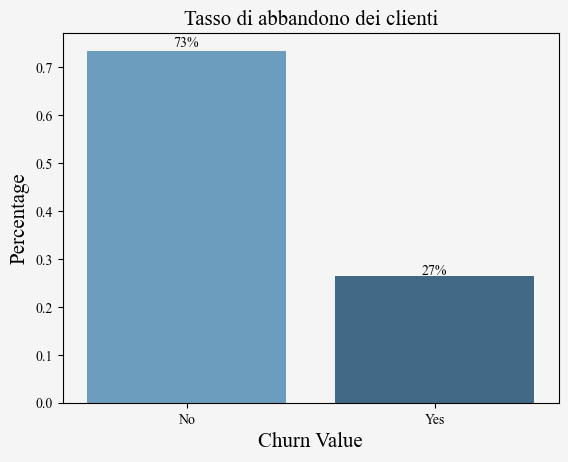

In [40]:
plt.title('Tasso di abbandono dei clienti')
eda_percentage = data['Churn Value'].value_counts(normalize=True).rename_axis('Churn Value').reset_index(name='Percentage')

ax = sns.barplot(x='Churn Value', y='Percentage', data=eda_percentage, palette='Blues_d')
ax.grid(visible=False, axis='both')
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:.0%}', (x + width/2, y + height*1.01), ha='center', fontweight='bold')
    ax.set_xticklabels(['No', 'Yes'])

### y - geo data *relationship*

In [41]:
lat = geodata['Latitude'].values
lon = geodata['Longitude'].values
churn = data['Churn Value'].values

### y - client data *relationship*

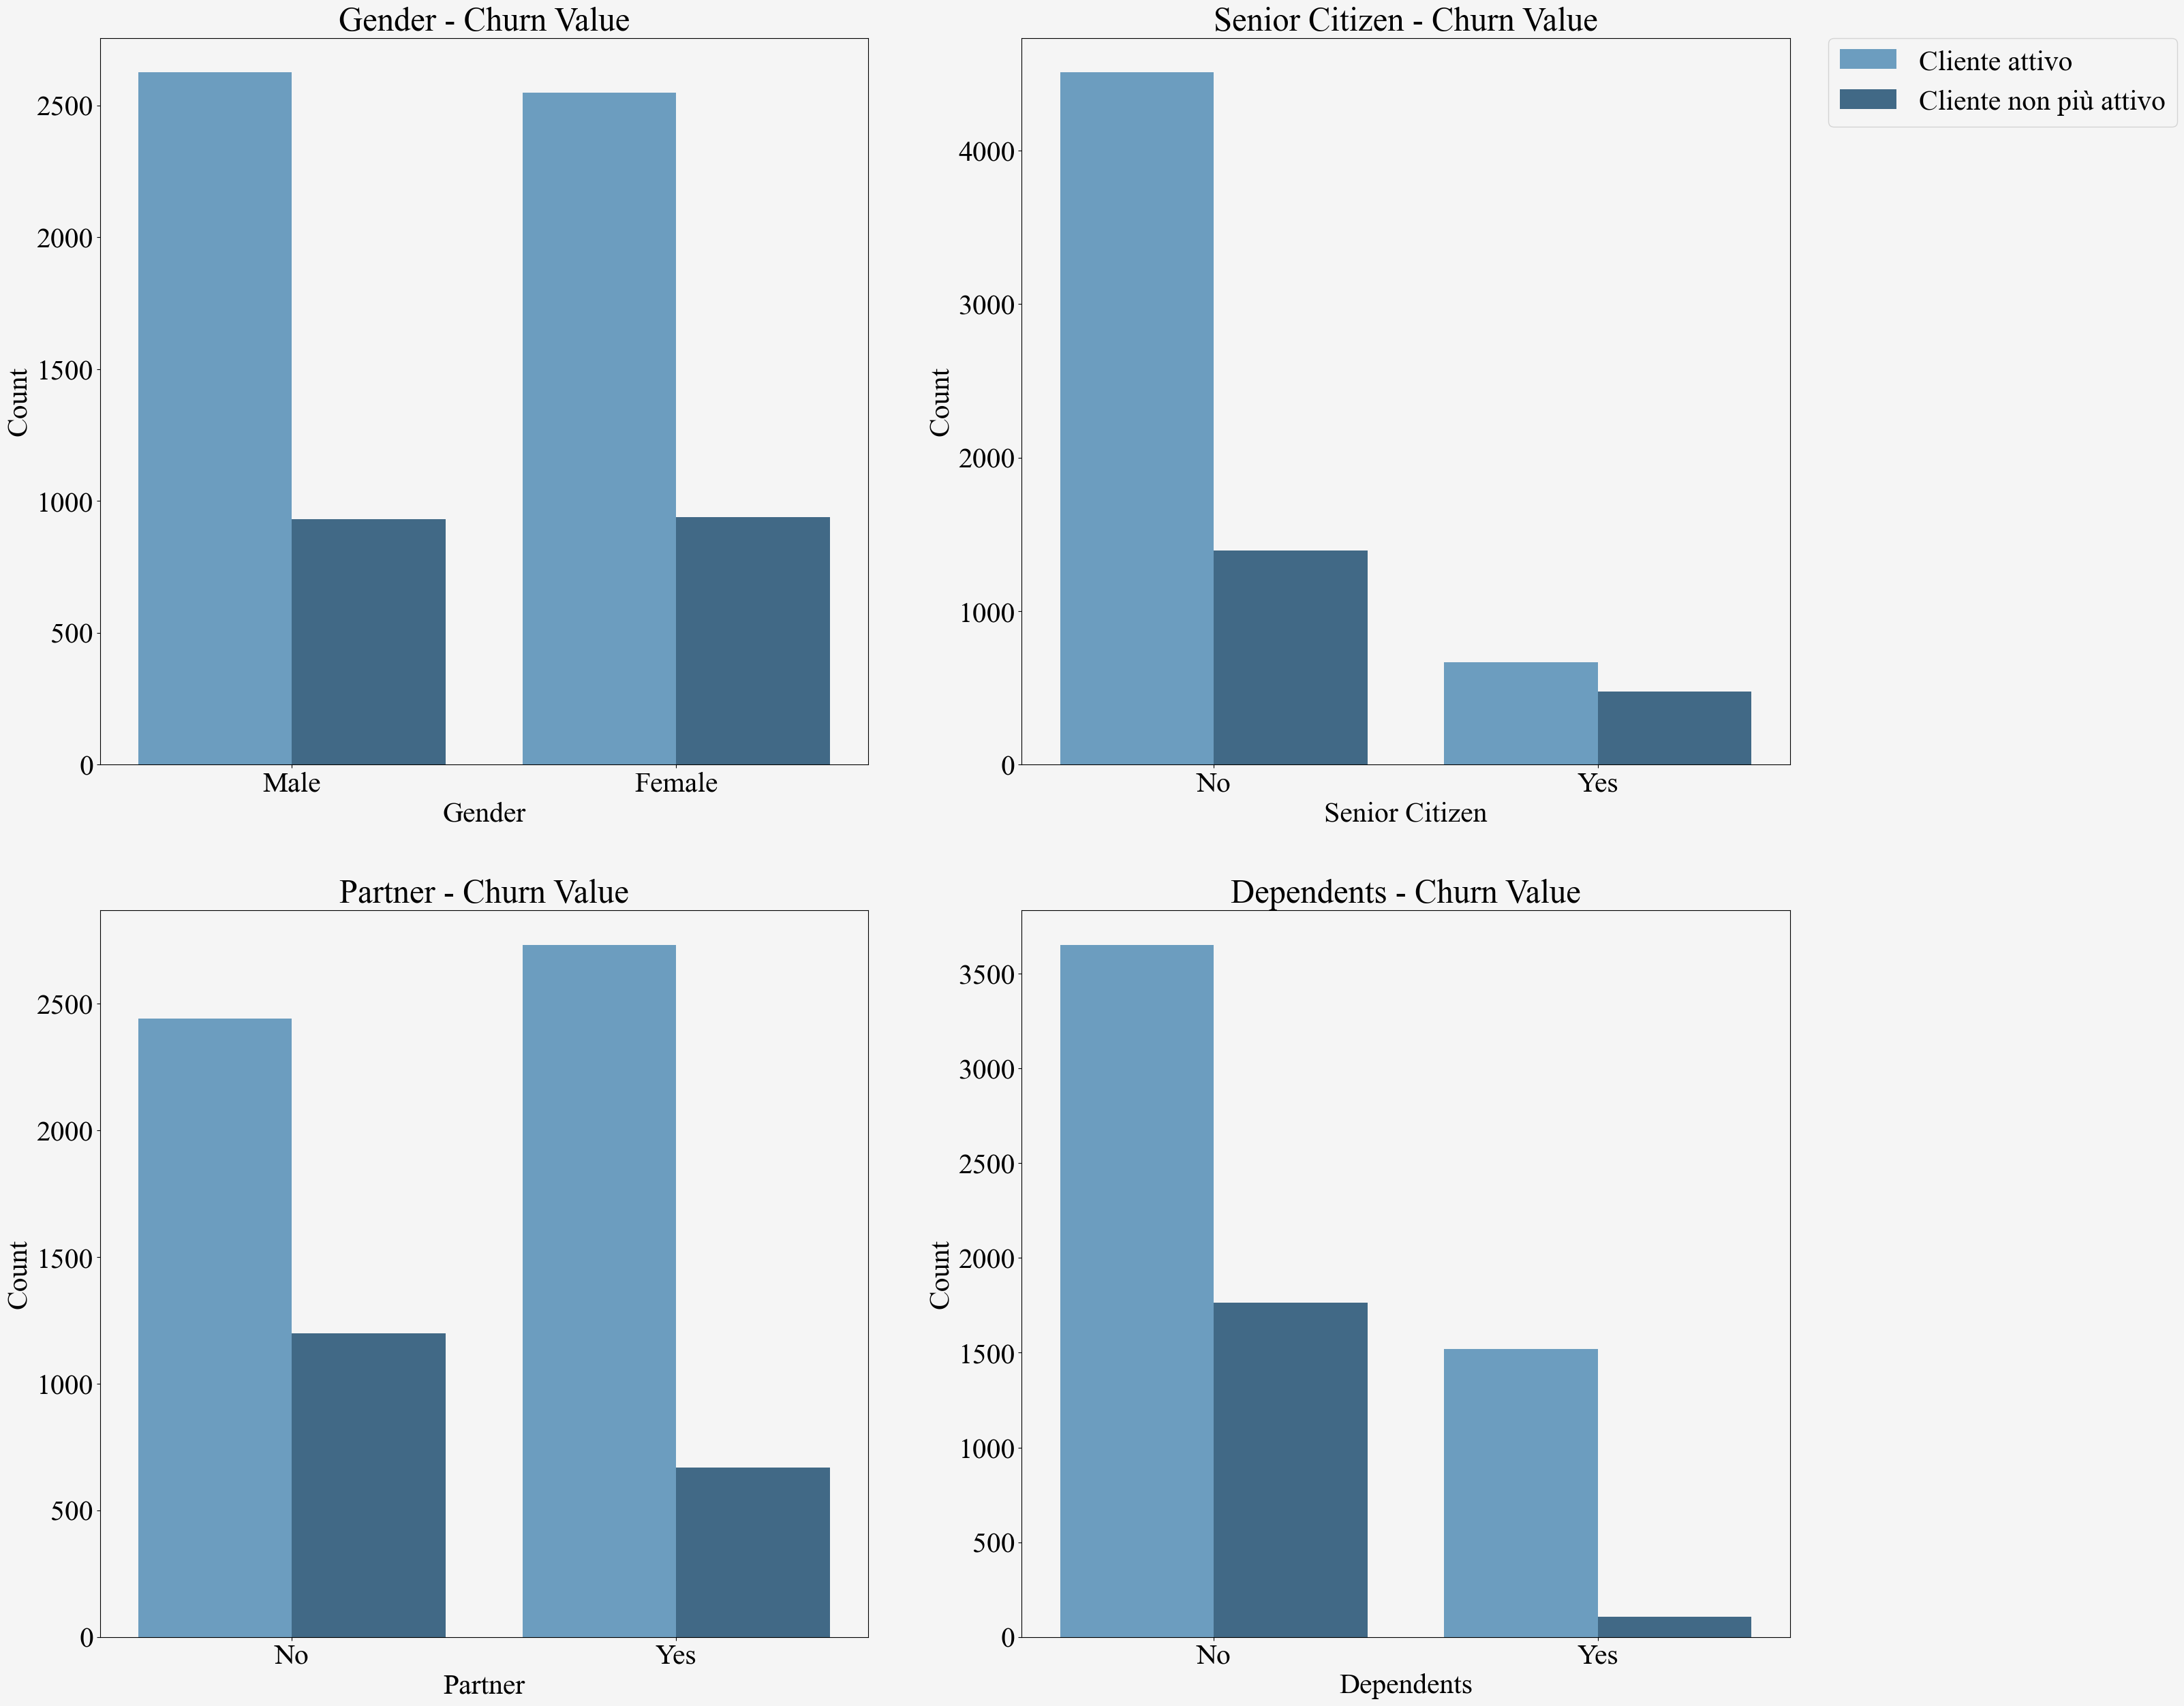

In [42]:
plt.subplot(2,2,1)
cp1 = sns.countplot(x = data['Gender'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Gender - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp1.set_xlabel('Gender', fontsize=30)
cp1.set_ylabel('Count', fontsize=30)
cp1.legend_.remove()

plt.subplot(2,2,2)
plt.subplots_adjust(right=4, top=5)
cp2 = sns.countplot(x = data['Senior Citizen'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Senior Citizen - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp2.set_xlabel('Senior Citizen', fontsize=30)
cp2.set_ylabel('Count', fontsize=30)
plt.legend(['Cliente attivo', 'Cliente non più attivo'], fontsize=30, 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(2,2,3)
cp3 = sns.countplot(x = data['Partner'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Partner - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp3.set_xlabel('Partner', fontsize=30)
cp3.set_ylabel('Count', fontsize=30)
cp3.legend_.remove()

plt.subplot(2,2,4)
cp4 = sns.countplot(x = data['Dependents'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Dependents - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp4.set_xlabel('Dependents', fontsize=30)
cp4.set_ylabel('Count', fontsize=30)
cp4.legend_.remove()

plt.show()

### y - services data *relationship*

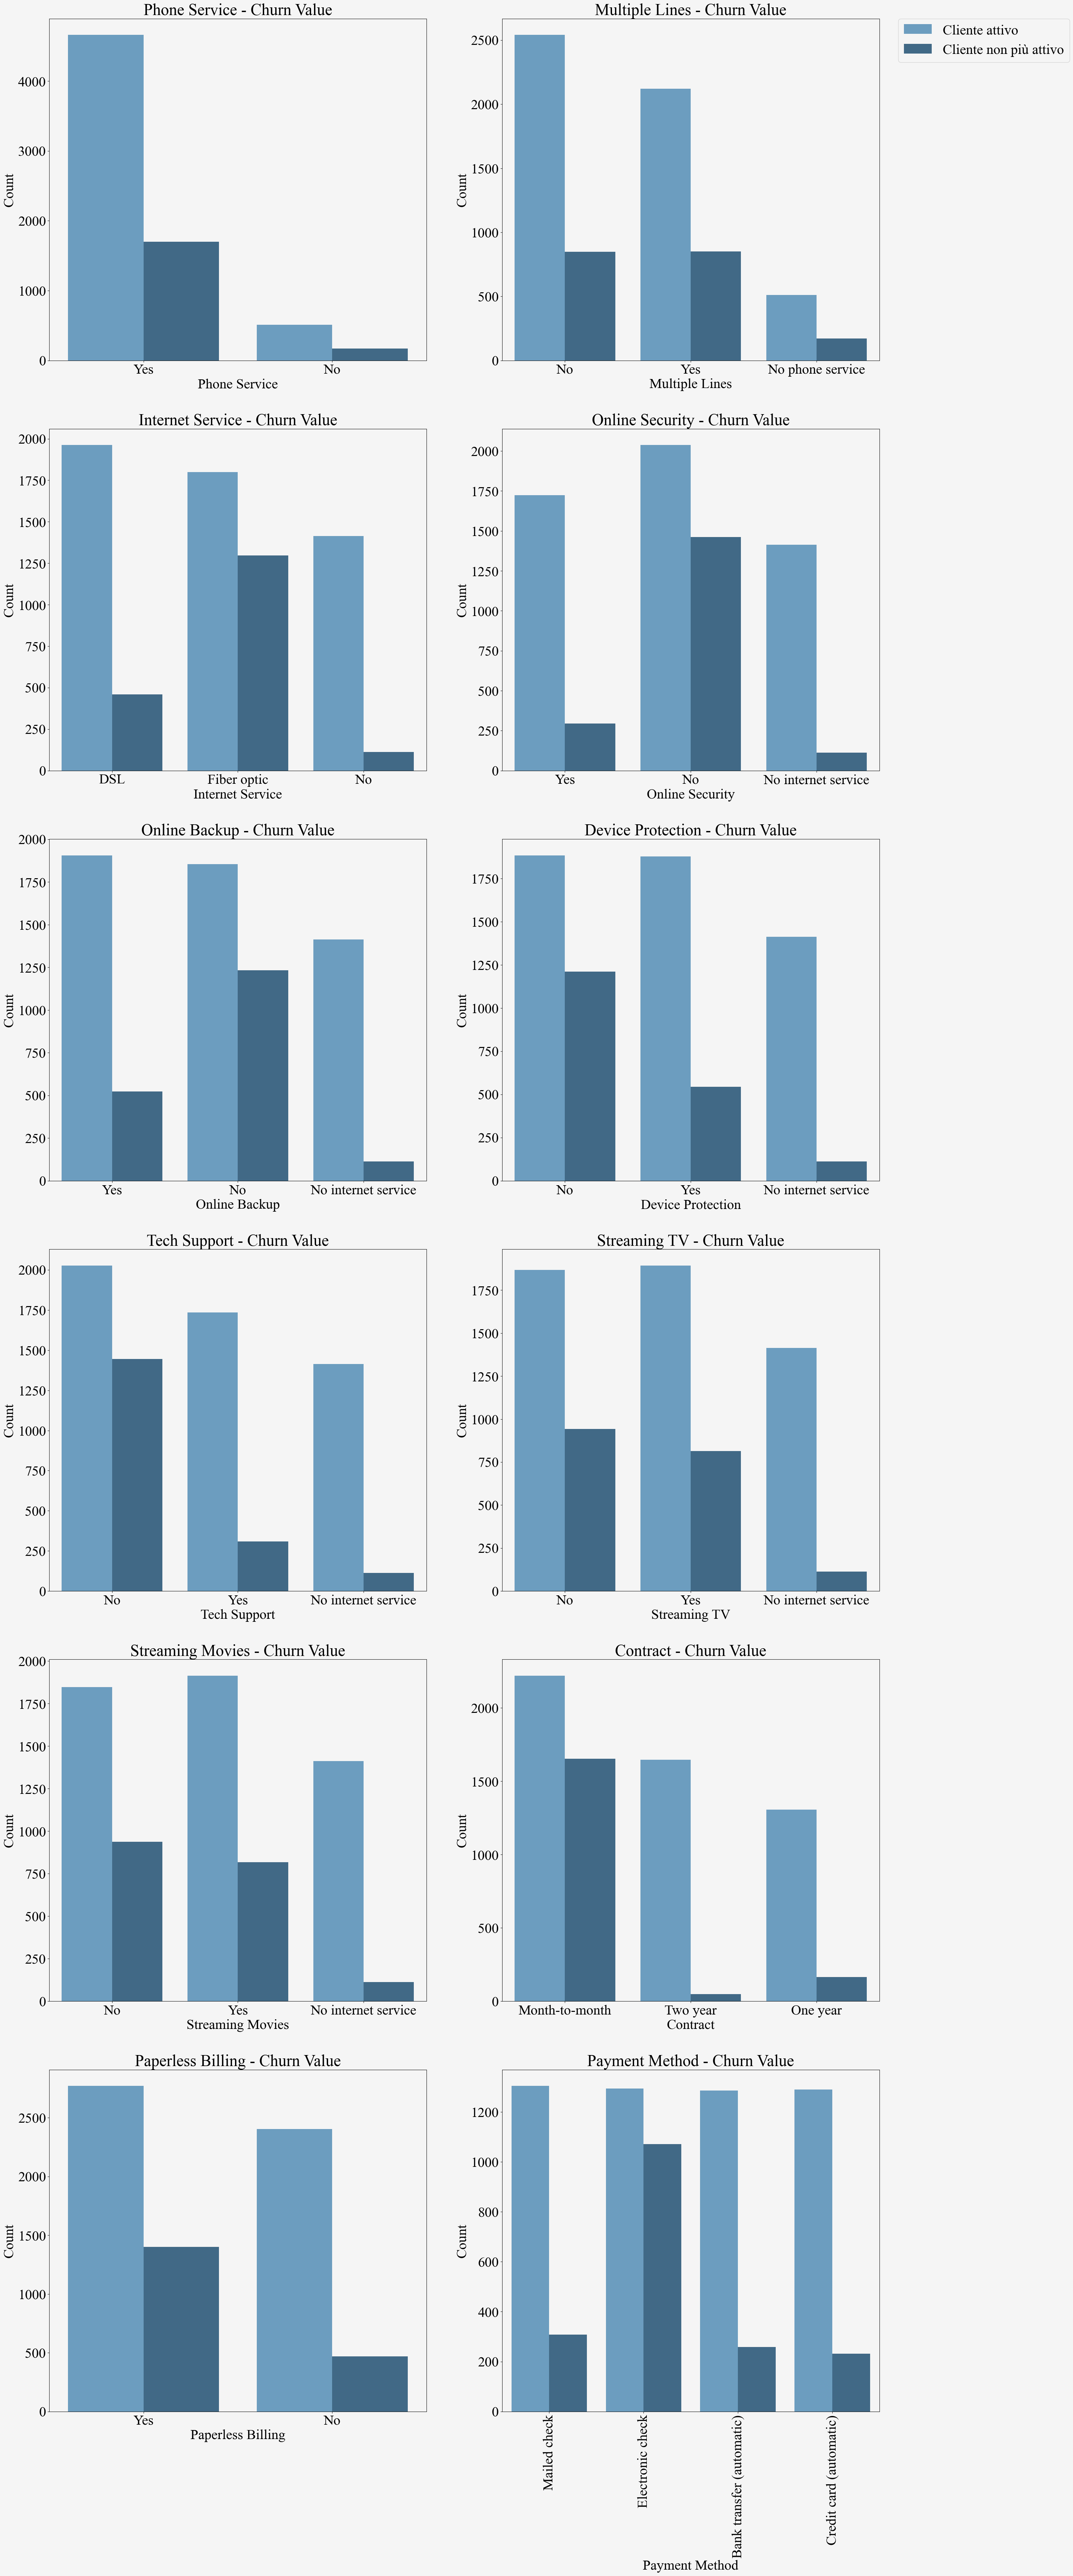

In [43]:
plt.subplot(6,2,1)
cp1 = sns.countplot(x = data['Phone Service'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Phone Service - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp1.set_xlabel('Phone Service', fontsize=30)
cp1.set_ylabel('Count', fontsize=30)
cp1.legend_.remove()

plt.subplot(6,2,2)
plt.subplots_adjust(right=4, top=15)
cp2 = sns.countplot(x = data['Multiple Lines'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Multiple Lines - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp2.set_xlabel('Multiple Lines', fontsize=30)
cp2.set_ylabel('Count', fontsize=30)
plt.legend(['Cliente attivo', 'Cliente non più attivo'], fontsize=30, 
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(6,2,3)
cp3 = sns.countplot(x = data['Internet Service'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Internet Service - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp3.set_xlabel('Internet Service', fontsize=30)
cp3.set_ylabel('Count', fontsize=30)
cp3.legend_.remove()

plt.subplot(6,2,4)
cp4 = sns.countplot(x = data['Online Security'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Online Security - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp4.set_xlabel('Online Security', fontsize=30)
cp4.set_ylabel('Count', fontsize=30)
cp4.legend_.remove()

plt.subplot(6,2,5)
cp5 = sns.countplot(x = data['Online Backup'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Online Backup - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp5.set_xlabel('Online Backup', fontsize=30)
cp5.set_ylabel('Count', fontsize=30)
cp5.legend_.remove()

plt.subplot(6,2,6)
cp6 = sns.countplot(x = data['Device Protection'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Device Protection - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp6.set_xlabel('Device Protection', fontsize=30)
cp6.set_ylabel('Count', fontsize=30)
cp6.legend_.remove()

plt.subplot(6,2,7)
cp7 = sns.countplot(x = data['Tech Support'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Tech Support - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp7.set_xlabel('Tech Support', fontsize=30)
cp7.set_ylabel('Count', fontsize=30)
cp7.legend_.remove()

plt.subplot(6,2,8)
cp8 = sns.countplot(x = data['Streaming TV'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Streaming TV - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp8.set_xlabel('Streaming TV', fontsize=30)
cp8.set_ylabel('Count', fontsize=30)
cp8.legend_.remove()

plt.subplot(6,2,9)
cp9 = sns.countplot(x = data['Streaming Movies'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Streaming Movies - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp9.set_xlabel('Streaming Movies', fontsize=30)
cp9.set_ylabel('Count', fontsize=30)
cp9.legend_.remove()

plt.subplot(6,2,10)
cp10 = sns.countplot(x = data['Contract'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Contract - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp10.set_xlabel('Contract', fontsize=30)
cp10.set_ylabel('Count', fontsize=30)
cp10.legend_.remove()

plt.subplot(6,2,11)
cp11 = sns.countplot(x = data['Paperless Billing'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Paperless Billing - Churn Value', fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
cp11.set_xlabel('Paperless Billing', fontsize=30)
cp11.set_ylabel('Count', fontsize=30)
cp11.legend_.remove()

plt.subplot(6,2,12)
cp12 = sns.countplot(x = data['Payment Method'], hue = data['Churn Value'], palette = 'Blues_d')
plt.title('Payment Method - Churn Value', fontsize=35)
plt.xticks(fontsize=30, rotation=90)
plt.yticks(fontsize=30)
cp12.set_xlabel('Payment Method', fontsize=30)
cp12.set_ylabel('Count', fontsize=30)
cp12.legend_.remove()

plt.show()

### y - numerical data *relationship*

In [44]:
Xy = pd.concat([X_num, target], axis=1)
Xy.head()

,Tenure Months,Monthly Charges,Total Charges,Churn Value
0,2,53.85,108.150002,1
1,2,70.70,151.649994,1
2,8,99.65,820.500000,1
3,28,104.80,3046.050049,1
4,49,103.70,5036.299805,1


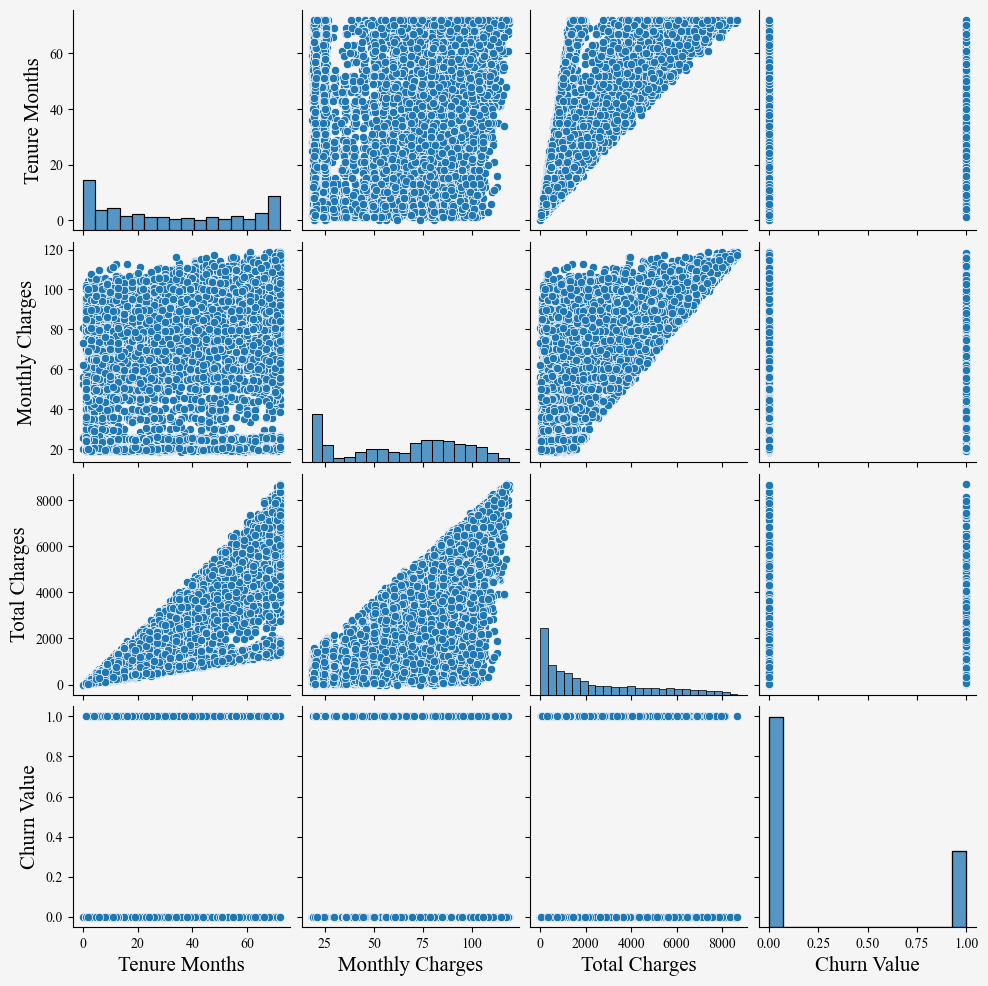

In [45]:
sns.pairplot(Xy);

## Model Implementation

In [46]:
X.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Paperless Billing', 'Multiple Lines_No',
       'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Internet Service_DSL', 'Internet Service_Fiber optic',
       'Internet Service_No', 'Online Security_No',
       'Online Security_No internet service', 'Online Security_Yes',
       'Online Backup_No', 'Online Backup_No internet service',
       'Online Backup_Yes', 'Device Protection_No',
       'Device Protection_No internet service', 'Device Protection_Yes',
       'Tech Support_No', 'Tech Support_No internet service',
       'Tech Support_Yes', 'Streaming TV_No',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Streaming Movies_No', 'Streaming Movies_No internet service',
       'Streaming Movies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic

In [47]:
X = X.to_numpy()

> Per lo split Train - Test si sceglie il metodo *StratifiedShuffleSplit* poiché la variabile target è molto sbilanciata.

In [48]:
rnd = 12
splitter = StratifiedShuffleSplit(random_state=rnd, test_size=0.4, n_splits=1)
train_idx, test_idx = next(splitter.split(X, target))
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = target[train_idx], target[test_idx]

In [49]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4225, 40), (4225,), (2818, 40), (2818,))

In [50]:
np.bincount(y_train)/len(y_train), np.bincount(y_test)/len(y_test)

(array([0.73467456, 0.26532544]), array([0.73456352, 0.26543648]))

### MinMaxScaler on numerical data

In [51]:
coln = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
       'Paperless Billing', 'Multiple Lines_No', 'Multiple Lines_No phone service', 'Multiple Lines_Yes',
       'Internet Service_DSL', 'Internet Service_Fiber optic', 'Internet Service_No', 'Online Security_No',
       'Online Security_No internet service', 'Online Security_Yes', 'Online Backup_No', 'Online Backup_No internet service',
       'Online Backup_Yes', 'Device Protection_No', 'Device Protection_No internet service', 'Device Protection_Yes',
       'Tech Support_No', 'Tech Support_No internet service', 'Tech Support_Yes', 'Streaming TV_No',
       'Streaming TV_No internet service', 'Streaming TV_Yes', 'Streaming Movies_No', 
       'Streaming Movies_No internet service', 'Streaming Movies_Yes', 'Contract_Month-to-month', 
       'Contract_One year', 'Contract_Two year', 'Payment Method_Bank transfer', 
       'Payment Method_Credit card', 'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Tenure Months', 'Monthly Charges', 'Total Charges']

mms = MinMaxScaler()

X_train_mms = mms.fit_transform(X_train)
X_train_mms = pd.DataFrame(X_train_mms, columns=coln)

X_test_mms = mms.transform(X_test)
X_test_mms = pd.DataFrame(X_test_mms, columns=coln)

In [52]:
X_train_mms.head()

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Paperless Billing,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check,Tenure Months,Monthly Charges,Total Charges
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.388889,0.359243,0.178349
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.861111,0.303438,0.347003
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.041667,0.262581,0.014152
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.194444,0.021425,0.031799
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.916667,0.014449,0.144612


In [53]:
X_test_mms.head()

,Gender,Senior Citizen,Partner,Dependents,Phone Service,Paperless Billing,Multiple Lines_No,Multiple Lines_No phone service,Multiple Lines_Yes,Internet Service_DSL,Internet Service_Fiber optic,Internet Service_No,Online Security_No,Online Security_No internet service,Online Security_Yes,Online Backup_No,Online Backup_No internet service,Online Backup_Yes,Device Protection_No,Device Protection_No internet service,Device Protection_Yes,Tech Support_No,Tech Support_No internet service,Tech Support_Yes,Streaming TV_No,Streaming TV_No internet service,Streaming TV_Yes,Streaming Movies_No,Streaming Movies_No internet service,Streaming Movies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,Payment Method_Bank transfer,Payment Method_Credit card,Payment Method_Electronic check,Payment Method_Mailed check,Tenure Months,Monthly Charges,Total Charges
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.430556,0.708022,0.325602
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.805556,0.419033,0.411045
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.902778,0.016442,0.149087
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.305556,0.781764,0.240245
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.222222,0.664674,0.158966


In [54]:
X_train_mms.shape, y_train.shape, X_test_mms.shape, y_test.shape

((4225, 40), (4225,), (2818, 40), (2818,))

### Feature Selection

In [55]:
def feature_selection(n_best_ft, Xtr, ytr, Xtest):
    ft = SelectKBest(f_classif, k = n_best_ft).fit(Xtr, ytr)
    scores_df = pd.DataFrame(ft.scores_)
    columns_df = pd.DataFrame(Xtr.columns)
    ft_scores = pd.concat([columns_df, scores_df], axis = 1)
    ft_scores.columns = ['X_feature', 'Score']
    ft_scores = ft_scores.sort_values('Score', ascending = False)
    best_features = ft_scores.head(n_best_ft).reset_index().drop(['index'], axis = 1)
    Xtr_fs = ft.transform(Xtr)
    Xtest_fs = ft.transform(Xtest)
    return best_features, Xtr_fs, Xtest_fs

In [56]:
best_ft, X_train_fs, X_test_fs = feature_selection(10, X_train_mms, y_train, X_test_mms)

In [57]:
best_ft

,X_feature,Score
0,Contract_Month-to-month,758.709553
1,Online Security_No,597.188205
2,Tenure Months,564.546890
3,Tech Support_No,536.096819
4,Internet Service_Fiber optic,474.177825
5,Payment Method_Electronic check,429.990284
6,Contract_Two year,410.999352
7,Online Backup_No,358.336587
8,Device Protection_No,294.061357
9,Dependents,278.107005


In [58]:
X_train_fs.shape, y_train.shape, X_test_fs.shape, y_test.shape

((4225, 10), (4225,), (2818, 10), (2818,))

### Models

In [59]:
def classification_models():
    models = []
    models.append(('kNN', KNeighborsClassifier(n_neighbors = 30, weights ='uniform')))
    models.append(('LogisticRegression', LogisticRegression()))
    models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=10)))
    models.append(('RandomForest', RandomForestClassifier(n_estimators=60, random_state=0)))
    models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=20)))
    models.append(('XGBClassifier', xgb.XGBClassifier(random_state=0,booster="gbtree")))
    
    return models

models = classification_models()
models

[('kNN', KNeighborsClassifier(n_neighbors=30)),
 ('LogisticRegression', LogisticRegression()),
 ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=10)),
 ('RandomForest', RandomForestClassifier(n_estimators=60, random_state=0)),
 ('GradientBoostingClassifier', GradientBoostingClassifier(random_state=20)),
 ('XGBClassifier',
  XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
           

In [60]:
scores = []
for name, algo in models:
    model = algo
    model.fit(X_train_fs, y_train)
    y_pred = model.predict(X_test_fs)
    f1score = f1_score(y_test, y_pred)
    scores.append(f1score)
    print(name, f1score)

kNN 0.5703422053231939
LogisticRegression 0.5927536231884059
DecisionTreeClassifier 0.518097941802697
RandomForest 0.556557945870923
GradientBoostingClassifier 0.5915290739411342
XGBClassifier 0.5586592178770949


Scegliamo per esempio la Regressione Logistica e la andiamo ad ottimizzare.

#### Model Selection

Train - Val

In [61]:
y_train = y_train.to_numpy()

In [62]:
splitter = StratifiedShuffleSplit(random_state=rnd, test_size=0.4, n_splits=1)
train_idx, val_idx = next(splitter.split(X_train_fs, y_train))
X_train, X_val = X_train_fs[train_idx], X_train_fs[val_idx]
y_train, y_val = y_train[train_idx], y_train[val_idx]

In [63]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2535, 10), (2535,), (1690, 10), (1690,))

In [64]:
np.bincount(y_train)/len(y_train), np.bincount(y_val)/len(y_val)

(array([0.73451677, 0.26548323]), array([0.73491124, 0.26508876]))

GridSearchCV

In [65]:
par_grid_rl = {'penalty': ['l1', 'l2'],
              'C': np.arange(.1, 5, .1)}
reg_log_opt = LogisticRegression(solver='saga',
                                 max_iter=1000)
reg_log_opt_gs = GridSearchCV(reg_log_opt, par_grid_rl)
reg_log_opt_gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=1000, solver='saga'),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'penalty': ['l1', 'l2']})

In [66]:
y_pred_reglog = reg_log_opt_gs.predict(X_val)

In [67]:
print('Best parameters: ', reg_log_opt_gs.best_params_)

Best parameters:  {'C': 0.2, 'penalty': 'l1'}


Test

In [68]:
reg_log_final = LogisticRegression(solver='saga', max_iter=1000, C=0.2, penalty='l1')

In [69]:
reg_log_final.fit(np.concatenate([X_train,X_val], axis=0), np.concatenate([y_train,y_val]))

LogisticRegression(C=0.2, max_iter=1000, penalty='l1', solver='saga')

In [70]:
y_pred_test =  reg_log_final.predict(X_test_fs)
f1_score(y_test, y_pred_test)

0.5915697674418605